<a href="https://colab.research.google.com/github/SiddTayi/ML-Projects/blob/main/LSTM_Temp_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
# File location and path
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
csv_path

'/root/.keras/datasets/jena_climate_2009_2016.csv'

In [4]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Datetime: %d.%m.%y \
10 minute intervals

In [5]:
df = df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [6]:
df.shape

(70091, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70091 entries, 5 to 420545
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        70091 non-null  object 
 1   p (mbar)         70091 non-null  float64
 2   T (degC)         70091 non-null  float64
 3   Tpot (K)         70091 non-null  float64
 4   Tdew (degC)      70091 non-null  float64
 5   rh (%)           70091 non-null  float64
 6   VPmax (mbar)     70091 non-null  float64
 7   VPact (mbar)     70091 non-null  float64
 8   VPdef (mbar)     70091 non-null  float64
 9   sh (g/kg)        70091 non-null  float64
 10  H2OC (mmol/mol)  70091 non-null  float64
 11  rho (g/m**3)     70091 non-null  float64
 12  wv (m/s)         70091 non-null  float64
 13  max. wv (m/s)    70091 non-null  float64
 14  wd (deg)         70091 non-null  float64
dtypes: float64(14), object(1)
memory usage: 8.0+ MB


In [11]:
df.index = pd.to_datetime(df['Date Time'], format = "%d.%m.%Y %H:%M:%S")

<Axes: xlabel='Date Time'>

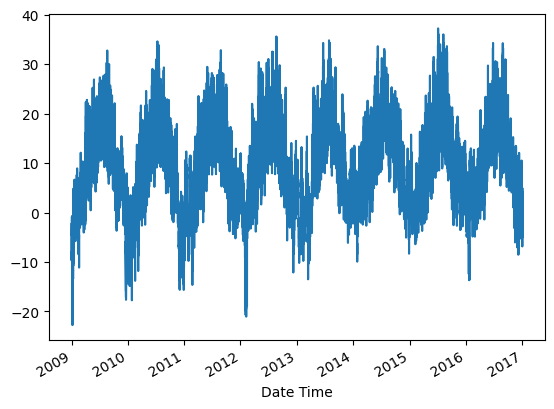

In [12]:
# Get temp
temp = df['T (degC)']
temp.plot()

In [13]:
# Take the first 5 hours and predict the 6th hour. Slide the window to the next value to repeat the same process.
# Input hours: X: [[1, 2, 3, 4, 5]] ==> Y: [6]
## Input hours: X2: [[2, 3, 4, 5, 6]] ==> Y: [7]
### Input hours: X3: [[3, 4, 5, 6, 7]] ==> Y: [8]

def df_to_XY(df, window_size = 5):
    df_numpy = df.to_numpy()
    X = [] # [[1, 2, 3, 4, 5]]
    y = [] # [6]
    for i in range(len(df_numpy) - window_size):
        #
        row = [[a] for a in df_numpy[i: i+window_size]]
        X.append(row)
        label = df_numpy[i+window_size]
        y.append(label)

    return np.array(X), np.array(y)


In [14]:
window_size = 5
X, y = df_to_XY(temp, window_size)
X.shape, y.shape

((70086, 5, 1), (70086,))

In [15]:
# Split them into train, test, and validation set

# First 60000 rows
x_train, y_train = X[:60000], y[:60000]

# Val
x_val, y_val = X[60000:65000], y[60000:65000]

# Test
x_test, y_test = X[65000:], y[65000:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

In [17]:
# Compile model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [19]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Only save the best model - The one with the lowest validation loss.
cp = ModelCheckpoint('model1/best_model.keras', save_best_only = True, verbose = 1)
model1.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.001), metrics = [RootMeanSquaredError()])

In [28]:
model1.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, callbacks = [cp])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.2408 - root_mean_squared_error: 3.9737
Epoch 1: val_loss improved from inf to 0.52540, saving model to model1/best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 20.2329 - root_mean_squared_error: 3.9729 - val_loss: 0.5254 - val_root_mean_squared_error: 0.7248
Epoch 2/10
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6861 - root_mean_squared_error: 0.8282
Epoch 2: val_loss improved from 0.52540 to 0.50102, saving model to model1/best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6861 - root_mean_squared_error: 0.8282 - val_loss: 0.5010 - val_root_mean_squared_error: 0.7078
Epoch 3/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6816 - root_mean_squared_error: 0.8256
Epoch 3: val_loss improved from 0.50102 to 0.49428, saving model to model1/best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6816 - root_mean_squared_error: 0.8255 - val_loss: 0.4943 - val_r

In [33]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/best_model.keras')

In [34]:
train_predictions = model1.predict(x_train).flatten()
train_results = pd.DataFrame(data = {"Train Predictions": train_predictions, "Actuals": y_train})
train_results

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


,Train Predictions,Actuals
0,-9.882600,-9.67
1,-9.679775,-9.17
2,-8.710765,-8.10
3,-7.238976,-7.66
4,-7.228353,-7.04
...,...,...
59995,6.262442,6.07
59996,7.258532,9.88
59997,12.349913,13.53
59998,15.860702,15.43


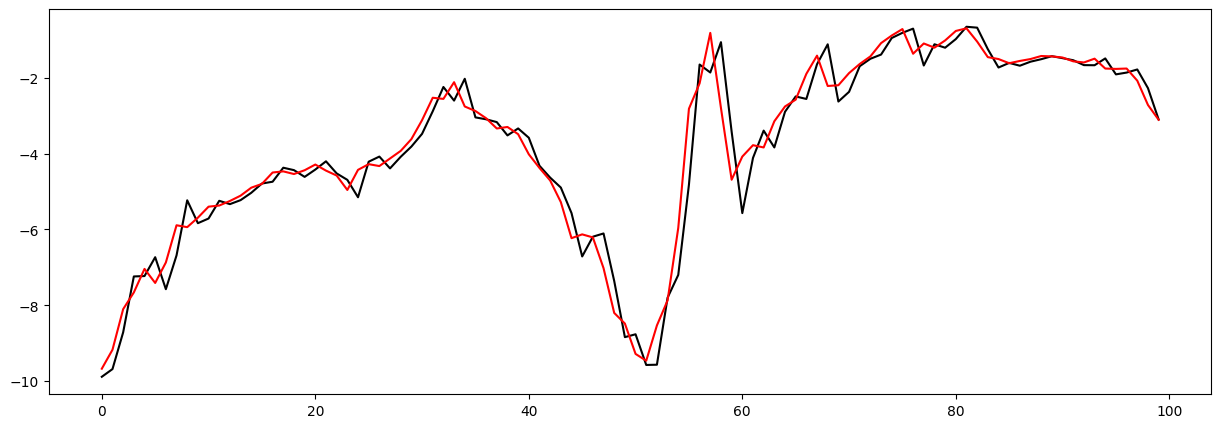

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 5))
plt.plot(train_results['Train Predictions'][:100], color = "black")
plt.plot(train_results['Actuals'][:100], color = "red")

In [40]:
# Do it on Validation dataset
val_predictions = model1.predict(x_val).flatten()
val_results = pd.DataFrame(data = {"Train Predictions": val_predictions, "Actuals": y_val})
val_results

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,Train Predictions,Actuals
0,15.872793,14.02
1,13.391482,13.67
2,13.154267,12.27
3,11.494302,11.19
4,10.480830,10.85
...,...,...
4995,17.761477,18.27
4996,17.727585,17.85
4997,17.221457,16.65
4998,15.953250,15.85


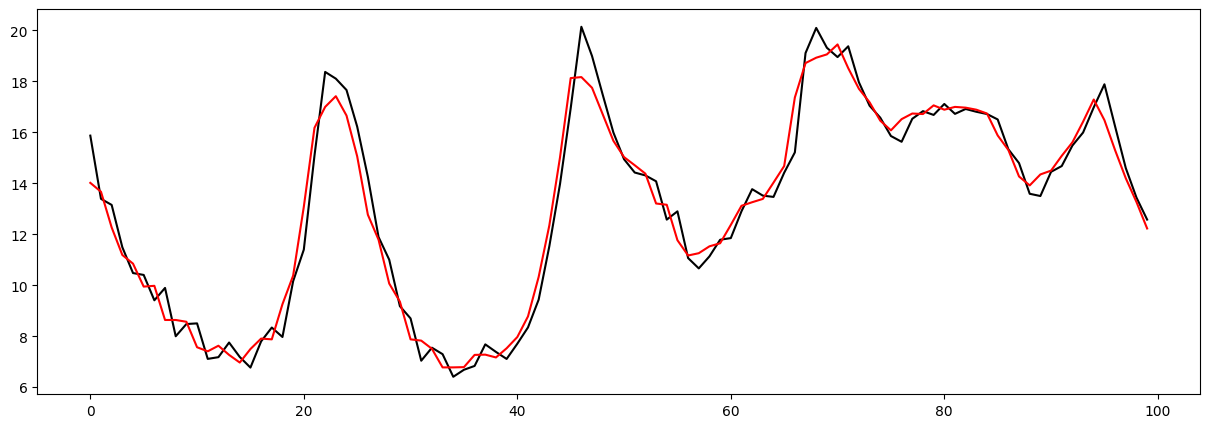

In [41]:
plt.figure(figsize = (15, 5))
plt.plot(val_results['Train Predictions'][:100], color = "black")
plt.plot(val_results['Actuals'][:100], color = "red")